# Research Project - *Challenge Data* 

## Data Loading & Librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from sklearn.decomposition import PCA 

# from statsmodels.tsa.seasonal import STL
# from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer

pio.renderers.default = 'browser'

In [2]:
x_train =  pd.read_csv('data/train_f_x.csv') # Train set - features
x_test = pd.read_csv('data/test_f_x_THurtzP.csv') # Test set
y_train = pd.read_csv('data/y_train_sncf.csv') # Number of validations / day - Train set
y_exemple = pd.read_csv('data/y_exemple_sncf_d9so9pm.csv') # Example of submission file

## Data Exploration

### Preprocessing & Transformation

Before exploring the data, we thought necessary to adapt the data of y_train at the same format as x_train. For this, we are doing slight modifications to the dataset. 

In [3]:
y_train[['date', 'station']] = y_train['index'].str.split('_', expand=True)
y_train.drop(columns=['index'], inplace=True)
y_train = y_train[['date', 'station', 'y']]

In [4]:
# Fusion x_train and y_train
df_train = x_train.merge(y_train, on=['date', 'station'], how='left')

# Rename column y to nb_valid
df_train.rename(columns={'y':'nb_valid'}, inplace=True)
df_train['date'] = pd.to_datetime(df_train['date'])
df_train.head()

,date,station,job,ferie,vacances,nb_valid
0,2015-01-01,1J7,1,1,1,7
1,2015-01-01,O2O,1,1,1,0
2,2015-01-01,8QR,1,1,1,9
3,2015-01-01,UMC,1,1,1,9
4,2015-01-01,FK3,1,1,1,28


### Qualitative Variable Analysis 

#### Temporal Features

In [5]:
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day_of_week'] = df_train['date'].dt.dayofweek

#### Correlation of the Descriptive Variables 

In [6]:
# Isolation of days with specific patterns
df_days = df_train[['date', 'job', 'vacances', 'ferie']].drop_duplicates()

# Calculate the intersection matrix via matrix multiplication
cols = ['job', 'vacances', 'ferie']
intersection_matrix = df_days[cols].T @ df_days[cols]

# PLOT
fig_3x3 = px.imshow(
    intersection_matrix,
    text_auto=True,                     
    x=['job', 'vacances', 'ferie'],
    y=['job', 'vacances', 'ferie'],
    title="Number of Days and Overlaps",
    color_continuous_scale='Blues'     
)

fig_3x3.update_coloraxes(showscale=False)
fig_3x3.update_xaxes(automargin=True)
fig_3x3.update_yaxes(automargin=True)

fig_3x3.show()

#### Global Temporal Evolution

We add lines of code to highlight some variables. To visualize these highlight, the lines of code should be uncommented.  

*Tip to comment multiple lines: Ctrl+k+c*  
*Tip to uncomment multiple lines: Ctrl+k+u*

In [7]:
# 1. Aggregate data by date to get total network traffic per day
df_daily_total = df_train.groupby('date')['nb_valid'].sum().reset_index()

# 2. 7-day rolling mean to smooth out daily fluctuations
df_daily_total['rolling_mean_7d'] = df_daily_total['nb_valid'].rolling(window=7).mean()

fig = go.Figure()

# Raw daily totals (lighter line)
fig.add_trace(go.Scatter(
    x=df_daily_total['date'], 
    y=df_daily_total['nb_valid'],
    mode='lines',
    name='Daily Total Validations',
    opacity=0.6,
    line=dict(color='lightblue')
))

# 7-day rolling mean (thicker line)
fig.add_trace(go.Scatter(
    x=df_daily_total['date'], 
    y=df_daily_total['rolling_mean_7d'],
    mode='lines',
    name='7-Day Rolling Mean',
    line=dict(color='navy', width=2)
))

#       UNCOMMENT THIS BLOCK TO ADD HOLIDAYS HIGHLIGHTING           #

# # Simplified extraction of vacation periods from the 'vacances' column
# holidays_df = df_train[['date', 'vacances']].drop_duplicates().sort_values('date')

# # Identify blocks of consecutive vacation days
# holidays_df['block'] = (holidays_df['vacances'] != holidays_df['vacances'].shift(1)).cumsum()
# vacation_periods = holidays_df[holidays_df['vacances'] == 1].groupby('block')['date'].agg(['min', 'max'])

# # --- Highlight of vacances ---
# for _, row in vacation_periods.iterrows():
#     fig.add_vrect(
#         x0=row['min'], 
#         x1=row['max'],
#         fillcolor="LightSalmon", 
#         opacity=0.2, 
#         layer="below", 
#         line_width=0,
#         name='School Holidays'
#     )
# # Legend entry for vacances  
# fig.add_trace(go.Scatter(
#     x=[None], y=[None],
#     mode='markers',
#     marker=dict(color="LightSalmon", symbol="square"),
#     name='School Holidays',
#     showlegend=True
# ))

# #       ---           #

fig.update_layout(
    width=1200,   # Largeur réduite pour tenir sur une demi-page
    height=600,
    title='Global Network Validations Over Time (2015-2022)',
    xaxis_title='Date',
    yaxis_title='Total Validations',
    template='plotly_white',
    hovermode='x unified' # Allows comparing both lines on hover
)

fig.show()

#### Global Temporal Evolution Across Years

In [8]:
# Daily patterns comparison across years (superposed)
fig_pattern = go.Figure()

years = sorted(df_train['year'].unique())

for i, year in enumerate(years):
    year_x_train_agg = df_train[df_train['year'] == year].groupby('date').agg(
        nb_valid=('nb_valid', 'sum'),
        job_label=('job', 'first'),
        public_holiday_label=('ferie', 'first'),
        holidays_label=('vacances', 'first')
    ).reset_index()
    
    year_x_train = year_x_train_agg.sort_values('date')
    year_x_train['day_of_year'] = year_x_train['date'].dt.dayofyear

    fig_pattern.add_trace(go.Scatter(
        x=year_x_train['day_of_year'],
        y=year_x_train['nb_valid'],

        
        customdata=year_x_train[['date', 'job_label', 'public_holiday_label', 'holidays_label']],

        mode='lines',
        name=str(year),
        line=dict(width=1.5),
        
        hovertemplate=(
            '<b>Date: %{customdata[0]|%d %b %Y}</b><br>' +
            'Validations: %{y:,.0f}<br>' +
            'Working day: %{customdata[1]}<br>' +
            'Public Holiday: %{customdata[2]}<br>' +
            'Holidays: %{customdata[3]}<extra></extra>'
        )
    ))

# Could be optimized
month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig_pattern.update_layout(
    title={
        'text': 'Comparison of Daily Patterns Across Years',
        'x': 0.5,
        'xanchor': 'center',
    },
    xaxis_title='Day of Year',
    yaxis_title='Total Number of Validations per Day',
    xaxis=dict(
        gridcolor='lightgray',
        showgrid=True,
        tickmode='array',
        tickvals=month_starts,
        ticktext=month_names
    ),
    yaxis=dict(gridcolor='lightgray'),
    plot_bgcolor='white',
    hovermode='closest',
    legend=dict(
        title='Year',
        orientation='v',
        yanchor='top',
        y=1,
        xanchor='left',
        x=1.01,
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='gray',
        borderwidth=1
    )
)

for month_start in month_starts:
    fig_pattern.add_vline(x=month_start, line_width=1, line_dash="dash", line_color="gray", opacity=0.3)

pio.show(fig_pattern, renderer='browser')

**Comments:**  
By plotting time series for the different years of the x_trainset, we are able to compare the daily patterns. Here what we can observe: 
* Ususally there is a lower frequentation of the metro during summer, especially in August. 
* There is a lower frequentation at the end of each year around New Year Eve, we can assume that usual users are out of the capital. 
* We can easily see how the COVID pandemic period affected the number of daily users:
  * **12.03.2020 (1,0,0)**: First announcement, closing schools and universities, use of remote working recomended.
  * **16.03.2025 (1,0,0)**: Second annoucement, allowing only necessary travels.
  * **17.03.2025 (1,0,0)**: Lockdown announcement.
  --> There is a drop of 2.2M of daily validations. 
  * At the end of the first lockdown we can see an increase of daily validations, but still really low compared to the other years' tendencies (mainly due to the remote working). But at the annoucement of the second French lockdown, the numbers decreased again. 
  * During **S1 2021**, the numbers are still lower the usual tendencies --> remote working, S2 number increased again. 
  * In **2022**, T1 a bit lower than the other years, and after we retrieve aproximately the same numbers as in 2018/2019 (but same tendancies than in 2015/2016)

### Temporal Analysis - Zoom

In [ ]:
# Parameters
year_target = 2019 # 2019 is ideal to show "clean" seasonality

# Global aggregation for the target year
# Calculate the sum of all stations per day
df_global_year = df_train[df_train['year'] == year_target].groupby('date').agg({
    'nb_valid': 'sum',
    'vacances': 'first',
    'job': 'first'
}).reset_index()

fig_saiso = go.Figure()

# Global traffic curve
fig_saiso.add_trace(go.Scatter(
    x=df_global_year['date'], 
    y=df_global_year['nb_valid'],
    mode='lines',
    line=dict(width=2),
    name='Total Network Traffic'
))

# Function to add shaded areas (Holidays and Weekends)
def highlight_period(fig, df, column, value, color):
    # Identify continuous blocks
    zones = df[df[column] == value].copy()
    if not zones.empty:
        zones['group'] = (zones['date'].diff().dt.days > 1).cumsum()
        for i, block in zones.groupby('group'):
            fig.add_vrect(
                x0=block['date'].min(), x1=block['date'].max(),
                fillcolor=color, opacity=0.2,
                layer="below", line_width=0,
                # Add legend only for the first block of each type
                #annotation_text=label if i == 0 else ""
            )

# Apply highlights
highlight_period(fig_saiso, df_global_year, 'vacances', 1, "LightSalmon")
#highlight_period(fig_saiso, df_global_year, 'job', 0, "gray", "Weekend")

fig_saiso.update_layout(
    title={
        'text': f'Global Seasonality - Year {year_target} - School Holidays Highlighted'
    },
    xaxis_title='Date',
    yaxis_title='Total Validations',
    template='plotly_white',
    width=600,
    height=400,
    font=dict(size=10),
    showlegend=False 
)

fig_saiso.update_yaxes(rangemode="tozero", gridcolor='lightgray')

fig_saiso.update_layout(
    margin=dict(l=5, r=5, t=40, b=5), 
    title={
        'y': 0.95,           
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig_saiso.update_xaxes(automargin=True)
fig_saiso.update_yaxes(automargin=True)


fig_saiso.show()

In [ ]:
# Parameters
year_target = 2019 # 2019 is ideal to show "clean" seasonality

# Global aggregation for the target year
# Calculate the sum of all stations per day
df_global_year = df_train[df_train['year'] == year_target].groupby('date').agg({
    'nb_valid': 'sum',
    'vacances': 'first',
    'job': 'first'
}).reset_index()

fig_saiso = go.Figure()

# Global traffic curve
fig_saiso.add_trace(go.Scatter(
    x=df_global_year['date'], 
    y=df_global_year['nb_valid'],
    mode='lines',
    line=dict(width=2),
    name='Total Network Traffic'
))

# Function to add shaded areas (Holidays and Weekends)
def highlight_period(fig, df, column, value, color):#, label):
    # Identify continuous blocks
    zones = df[df[column] == value].copy()
    if not zones.empty:
        zones['group'] = (zones['date'].diff().dt.days > 1).cumsum()
        for i, block in zones.groupby('group'):
            fig.add_vrect(
                x0=block['date'].min(), x1=block['date'].max(),
                fillcolor=color, opacity=0.2,
                layer="below", line_width=0,
                # Add legend only for the first block of each type
                #annotation_text=label if i == 0 else ""
            )

# Apply highlights
#highlight_period(fig_saiso, df_global_year, 'vacances', 1, "orange", "Vacances")
highlight_period(fig_saiso, df_global_year, 'job', 1, "lightgreen")#, "Weekday")

fig_saiso.update_layout(
    title={
        'text': f'Global Seasonality - Year {year_target} - Job Highlighted'
    },
    xaxis_title='Date',
    yaxis_title='Total Validations',
    template='plotly_white',
    width=600,
    height=400,
    font=dict(size=10),
    showlegend=False 
)

fig_saiso.update_yaxes(rangemode="tozero", gridcolor='lightgray')

fig_saiso.update_layout(
    margin=dict(l=5, r=5, t=40, b=5), 
    title={
        'y': 0.95,          
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },

    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig_saiso.update_xaxes(automargin=True)
fig_saiso.update_yaxes(automargin=True)

fig_saiso.show()

In [22]:
year_target = 2019
month_target = 6 

df_month = df_train[(df_train['year'] == year_target) & 
                    (df_train['date'].dt.month == month_target)]

df_month_agg = df_month.groupby('date').agg({
    'nb_valid': 'sum',
    'vacances': 'first',
    'job': 'first'
}).reset_index()

# Identify Sundays for the markers
sundays = df_month_agg[df_month_agg['date'].dt.dayofweek == 6]

fig_month = go.Figure()

# Main traffic line with small markers
fig_month.add_trace(go.Scatter(
    x=df_month_agg['date'], 
    y=df_month_agg['nb_valid'],
    mode='lines+markers', 
    line=dict(width=2),
    marker=dict(size=6),   
    name='Daily Traffic'
))

# Sunday Markers (Diamonds) 
fig_month.add_trace(go.Scatter(
    x=sundays['date'],
    y=sundays['nb_valid'],
    mode='markers',
    marker=dict(color='red', size=8, symbol='diamond'),
    name='Sundays'
))

# Function to add shaded areas 
def highlight_month_zones(fig, df, column, value, color):
    zones = df[df[column] == value].copy()
    if not zones.empty:
        zones['group'] = (zones['date'].diff().dt.days > 1).cumsum()
        for i, block in zones.groupby('group'):
            fig.add_vrect(
                x0=block['date'].min() - pd.Timedelta(hours=12), 
                x1=block['date'].max() + pd.Timedelta(hours=12),
                fillcolor=color, opacity=0.2,
                layer="below", line_width=0
            )

highlight_month_zones(fig_month, df_month_agg, 'job', 1, "Lightgreen")
highlight_month_zones(fig_month, df_month_agg, 'vacances', 1, "lightsalmon")

fig_month.update_layout(
    title={
        'text': f'Number of Validations per Day - Job Highlighted',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Date',
    yaxis_title='Total Validations',
    template='plotly_white',
    height=400,
    width=750, 
    font=dict(size=10),
    margin=dict(l=5, r=5, t=40, b=5),
    
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    )
)
fig_month.update_xaxes(
    tickformat="%d %b %Y",
    automargin=True
)
fig_month.update_yaxes(automargin=True)

fig_month.show()

### Seasonality Analysis 

#### Seasonality - Weekly Pattern

In [9]:
df_weekly_avg = df_train.groupby('day_of_week')['nb_valid'].mean().reset_index()

day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_weekly_avg['day_name'] = df_weekly_avg['day_of_week'].map(day_map)

fig_week = px.bar(  
    df_weekly_avg, 
    x='day_name', 
    y='nb_valid',
    title='Average Validations by Day of the Week',
    labels={'nb_valid': 'Average Validations', 'day_name': 'Day'},
    template='plotly_white',
    width=700,
)

fig_week.update_traces(marker_color='indianred')
fig_week.show()

#### Seasonnality - Yearly Pattern 

In [10]:
# Yearly seasonal patterns analysis
# One line per year to compare seasonal trends across years.

df_month_year = df_train.groupby(['year', 'month'])['nb_valid'].mean().reset_index()

fig_seasonal = px.line(
    df_month_year,
    x='month',
    y='nb_valid',
    color='year', 
    title='Average Daily Validations: Yearly Comparison',
    labels={'nb_valid': 'Avg Daily Validations', 'month': 'Month', 'year': 'Year'},
    markers=True,
    template='plotly_white'
)

# Force the X-axis to show all months (1-12)
fig_seasonal.update_xaxes(dtick=1)

fig_seasonal.show()

# --------------------------------------------------------------------------------
# VISUALIZATION 2: HEATMAP (MONTH x YEAR)
# --------------------------------------------------------------------------------
# Shows correlations and anomalies over time.

heatmap_data = df_month_year.pivot(index='year', columns='month', values='nb_valid')

fig_heatmap = px.imshow(
    heatmap_data,
    labels=dict(x="Month", y="Year", color="Avg Validations"),
    x=heatmap_data.columns,
    y=heatmap_data.index,
    title='Heatmap of Validations (Month vs Year)',
    color_continuous_scale='RdBu',
    aspect='auto'
)

fig_heatmap.update_traces(xgap=1, ygap=1)

fig_heatmap.show()

---

## PCA

In [11]:
# Extract data for PCA comparison between 2019 and 2022

df_2022 = df_train[df_train['year'] == 2022].copy()
df_2022.reset_index(drop=True, inplace=True)
df_2019 = df_train[df_train['year'] == 2019].copy()
df_2019.reset_index(drop=True, inplace=True)

### PCA Analysis on the Global Profil

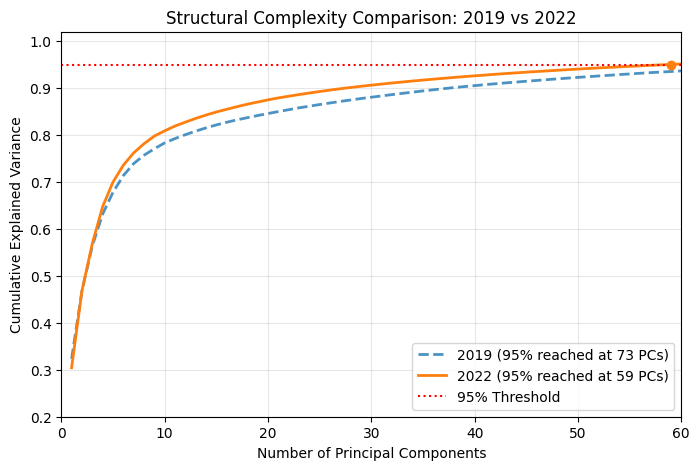

In [12]:
def get_pca_variance(df, year_label):
    """
    Function to compute cumulative variance for a given year.
    """
    daily_profile = df.pivot_table(
        index='station', 
        columns='date', 
        values='nb_valid'
    ).fillna(0)

    # Normalisation 
    X = daily_profile.div(daily_profile.sum(axis=1), axis=0)

    # PCA
    n_comp = min(X.shape)
    pca = PCA(n_components=n_comp)
    pca.fit(X)

    # Cumulative variance calculation
    cumulative_var = np.cumsum(pca.explained_variance_ratio_)
    n_95 = np.where(cumulative_var >= 0.95)[0][0] + 1
    
    return cumulative_var, n_95

cum_var_2019, n95_2019 = get_pca_variance(df_2019, "2019")
cum_var_2022, n95_2022 = get_pca_variance(df_2022, "2022")


plt.figure(figsize=(8, 5))

# Curve 2019 (Blue)
plt.plot(range(1, len(cum_var_2019) + 1), cum_var_2019, 
         color='#1f77b4', linestyle='--', linewidth=2, alpha=0.8,
         label=f'2019 (95% reached at {n95_2019} PCs)')

# Curve 2022 (Orange)
plt.plot(range(1, len(cum_var_2022) + 1), cum_var_2022, 
         color='#ff7f0e', linewidth=2,
         label=f'2022 (95% reached at {n95_2022} PCs)')

# 95% Threshold Line
plt.axhline(y=0.95, color='red', linestyle=':', label='95% Threshold')

# Vertical markers to visualize the gap
plt.scatter([n95_2019], [0.95], color='#1f77b4', zorder=5)
plt.scatter([n95_2022], [0.95], color='#ff7f0e', zorder=5)

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Structural Complexity Comparison: 2019 vs 2022')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 60) 
plt.ylim(0.2, 1.02)

plt.show()

### Structural Analysis Methodology: Selection and PCA

This code implements a three-step analysis to characterize the behavioral evolution of the network (2019 vs. 2022) using a representative sample.

#### Station Selection Strategy

To visualize the diversity of the network without overcrowding the plot, a selection of **12 "sentinel" stations** is made based on the 2019 annual volumes (the "normal" reference year).
The sampling uses quantiles to cover the entire scale of the network:

* **The Giants (Top 3 absolute):** The largest hubs in the network.
* **Regional Hubs (90th percentile):** High-traffic stations.
* **Standard Stations (Median):** The "core" of the network (typical commuter stations).
* **Small Stations (10th percentile):** Low-traffic stations.

#### Visualization of the Drift (2019 -> 2022)

The `compare_pca_interactive_legend` function generates a dynamic scatter plot (Plotly) to visualize the structural change:

* **Normalization:** Data is transformed into weekly probability profiles (Sum = 1) to compare the **shape** of the traffic (behavior) rather than the absolute volume.
* **Latent Space (Fit 2019):** The PCA is trained *only* on 2019 data. This establishes the "pre-COVID normality" as the reference frame.
* **Projection (Transform 2022):** The 2022 profiles are projected into this existing space.
* **Visualization:**
* **Blue dots:** Position in 2019.
* **Red crosses:** Position in 2022.
* **Dashed lines:** Represent the behavioral "migration" (the drift) of each station.



#### Semantic Interpretation of Axes (Loadings)

The final block provides mathematical meaning to the PC1 and PC2 axes by displaying the *loadings* (weights of the days of the week) as bar plots:

* **PC1 (Commuter Signal):** Opposes weekdays (negative weights) to the weekend (positive weights). This is the "Work vs. Rest" axis.
* **PC2 (Weekend Structure):** Opposes Saturday (negative) to Sunday (positive). This axis captures the nuance in the type of leisure or commercial activity during the weekend.

In [13]:
# Computation of station volumes for selection
# Using 2019 as it represents the "normal" hierarchy of the network
vol_2019 = df_train[df_train['year'] == 2019].groupby('station')['nb_valid'].sum().sort_values(ascending=False)

# Definition of categories by quantile
n_stations = len(vol_2019)

# 1. Giants (Top 3 absolute)
top_giants = vol_2019.head(3).index.tolist()

# 2. Regional Hubs (Around 90th percentile)
idx_high = int(n_stations * 0.10) # Top 10%
high_stations = vol_2019.iloc[idx_high : idx_high + 3].index.tolist()

# 3. Standard Stations (Median)
idx_med = int(n_stations * 0.50)
medium_stations = vol_2019.iloc[idx_med : idx_med + 3].index.tolist()

# 4. Small Stations (Around 10th percentile)
idx_low = int(n_stations * 0.90) 
small_stations = vol_2019.iloc[idx_low : idx_low + 3].index.tolist()

# Fusion of the selection list
selected_stations_ids = top_giants + high_stations + medium_stations + small_stations

print("=== Selected Stations (Based on 2019 volume) ===")
print(f"Top 3 Giants (Millions of validations): \n{vol_2019.loc[top_giants] / 1e6}\n")
print(f"Hubs (High Volume): \n{vol_2019.loc[high_stations] / 1e6}\n")
print(f"Standard (Median): \n{vol_2019.loc[medium_stations] / 1e6}\n")
print(f"Small Stations: \n{vol_2019.loc[small_stations] / 1e6}")

=== Selected Stations (Based on 2019 volume) ===
Top 3 Giants (Millions of validations): 
station
GMD    49.168052
CQT    26.823681
KBV    26.719958
Name: nb_valid, dtype: float64

Hubs (High Volume): 
station
ZII    4.095913
H1M    3.909606
CM6    3.896415
Name: nb_valid, dtype: float64

Standard (Median): 
station
V2P    0.601927
F30    0.593733
6FB    0.591081
Name: nb_valid, dtype: float64

Small Stations: 
station
DF2    0.029101
BZ0    0.028608
LHY    0.027596
Name: nb_valid, dtype: float64


In [14]:
def compare_pca_interactive_legend(df, station_list, year_ref=2019, year_comp=2022):
    
    def get_data_per_year(year):
        df_year = df[df['year'] == year]
        # Hebdo Profile Pivot
        pivot = df_year.pivot_table(index='station', columns='day_of_week', values='nb_valid', aggfunc='mean').fillna(0)
        # Normalisation (Sum = 1) -> Comparison of the shape
        X_norm = pivot.div(pivot.sum(axis=1), axis=0)
        
        vol_mean = df_year.groupby('station')['nb_valid'].mean() # Mean volume per day
        return X_norm, vol_mean

    X_ref, vol_ref = get_data_per_year(year_ref)
    X_comp, vol_comp = get_data_per_year(year_comp)

    # Intersection of stations (must exist in both years)
    common_stations = X_ref.index.intersection(X_comp.index)
    
    # Restrict matrices to common stations for PCA fit
    X_ref = X_ref.loc[common_stations]
    X_comp = X_comp.loc[common_stations]

    pca = PCA(n_components=2)
    X_ref_pca = pca.fit_transform(X_ref) # Fit on 2019
    X_comp_pca = pca.transform(X_comp)   # Projection 2022

    # Global dataframe
    df_compare = pd.DataFrame({
        'station': common_stations,
        'PC1_ref': X_ref_pca[:, 0],
        'PC2_ref': X_ref_pca[:, 1],
        'vol_ref': vol_ref.loc[common_stations].values,
        'PC1_comp': X_comp_pca[:, 0],
        'PC2_comp': X_comp_pca[:, 1],
        'vol_comp': vol_comp.loc[common_stations].values
    })

    # --- FILTERING BY SELECTED LIST ---
    # This is where we replace the random sample with the list
    # We only keep stations that are IN the provided list
    mask = df_compare['station'].isin(station_list)
    sample_stations = df_compare[mask].copy()

    # Security check
    if sample_stations.empty:
        print("Warning: No stations from the list were found in the common data.")
        return go.Figure()

    # --- Preparation for Plotly (3 Unique Traces) ---
    
    # Hover Texts
    hover_text_ref = [
        f"<b>{row.station}</b><br>Vol. {year_ref}: {row.vol_ref:.0f}" 
        for _, row in sample_stations.iterrows()
    ]
    
    hover_text_comp = [
        f"<b>{row.station}</b><br>Vol. {year_comp}: {row.vol_comp:.0f}" 
        for _, row in sample_stations.iterrows()
    ]

    # Construction of dashed lines (with None)
    x_lines = []
    y_lines = []
    for _, row in sample_stations.iterrows():
        x_lines.extend([row['PC1_ref'], row['PC1_comp'], None])
        y_lines.extend([row['PC2_ref'], row['PC2_comp'], None])

    # --- Creation of the Plot ---
    fig = go.Figure()

    # TRACE 1 : Lines (Movement)
    fig.add_trace(go.Scatter(
        x=x_lines,
        y=y_lines,
        mode='lines',
        name='Drift',
        line=dict(color='gray', width=1, dash='dot'),
        hoverinfo='skip'
    ))

    # TRACE 2 : Points 2019 (Departure)
    fig.add_trace(go.Scatter(
        x=sample_stations['PC1_ref'],
        y=sample_stations['PC2_ref'],
        mode='markers',
        name=f'{year_ref}',
        marker=dict(color='rgba(31, 119, 180, 0.6)', size=8, symbol='circle'),
        text=hover_text_ref,
        hovertemplate="%{text}<extra></extra>"
    ))

    # TRACE 3 : Points 2022 (Arrival)
    fig.add_trace(go.Scatter(
        x=sample_stations['PC1_comp'],
        y=sample_stations['PC2_comp'],
        mode='markers+text',
        name=f'{year_comp}',
        marker=dict(color='red', size=10, symbol='x'),
        
        text=sample_stations['station'],
        textposition="top center",
        textfont=dict(size=10, color='black'),
        
        hovertext=hover_text_comp, 
        hovertemplate="%{hovertext}<extra></extra>"
    ))

    # Layout
    fig.update_layout(
        title=f"Behavioral Migration ({year_ref} → {year_comp}) - Strategic Selection",
        xaxis_title=f"PC1 - {pca.explained_variance_ratio_[0]:.1%} Var",
        yaxis_title=f"PC2 - {pca.explained_variance_ratio_[1]:.1%} Var",
        template='plotly_white',
        width=1000, height=700,
        legend=dict(
            yanchor="top", y=0.99,
            xanchor="left", x=0.01,
            bgcolor="rgba(255, 255, 255, 0.8)"
        )
    )

    return fig

fig_strategic = compare_pca_interactive_legend(df_train, station_list=selected_stations_ids)
fig_strategic.show()

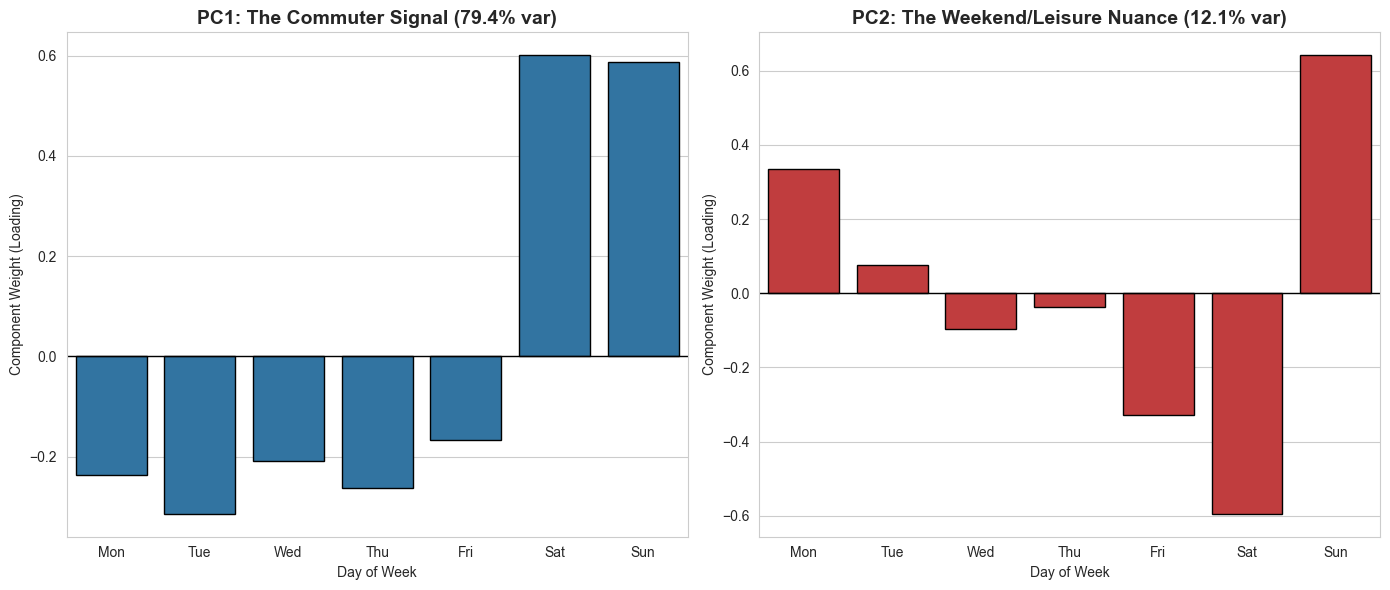

In [15]:
# --- Data Preparation (On 2019, our reference) ---
# Normalized weekly matrix
df_2019 = df_train[df_train['year'] == 2019]
pivot_2019 = df_2019.pivot_table(index='station', columns='day_of_week', values='nb_valid', aggfunc='mean').fillna(0)
X_2019 = pivot_2019.div(pivot_2019.sum(axis=1), axis=0)

# --- PCA Fitting ---
pca = PCA(n_components=2)
pca.fit(X_2019)

# --- Extraction of Loadings ---
days_en = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1 (Commuter Intensity)', 'PC2 (Weekend Structure)'],
    index=days_en
)

sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# Plot PC1 
plt.subplot(1, 2, 1)
sns.barplot(x=loadings.index, y=loadings['PC1 (Commuter Intensity)'], color='#1f77b4', edgecolor='black')
plt.title(f"PC1: The Commuter Signal ({pca.explained_variance_ratio_[0]:.1%} var)", fontsize=14, fontweight='bold')
plt.axhline(0, color='black', linewidth=1)
plt.ylabel("Component Weight (Loading)")
plt.xlabel("Day of Week")

# Plot PC2 
plt.subplot(1, 2, 2)
sns.barplot(x=loadings.index, y=loadings['PC2 (Weekend Structure)'], color='#d62728', edgecolor='black')
plt.title(f"PC2: The Weekend/Leisure Nuance ({pca.explained_variance_ratio_[1]:.1%} var)", fontsize=14, fontweight='bold')
plt.axhline(0, color='black', linewidth=1)
plt.ylabel("Component Weight (Loading)")
plt.xlabel("Day of Week")

plt.tight_layout()
plt.show()